In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gradient Boosting

## Read Data

In [2]:
#data from here https://www.kaggle.com/c/boston-housing/overview
df = pd.read_csv('https://raw.githubusercontent.com/shestakoff/hse_se_ml/master/2020/s11-boosting/data/boston_train.csv').drop(columns = 'ID')

 Prediction of house price in Boston.
 
 Why it's important? Because it can help people determine a fair price at home.

In [3]:
X = df.drop(columns = 'medv').values
y = df['medv'].values

In [4]:
X.shape

(333, 13)

## Before doing

definition of huber_loss: https://en.wikipedia.org/wiki/Huber_loss

Implement function which calculate $z_i$ from gradient boosting alogirithm (minus gradient of loss function). Implement for all possible loss function (mse, hl, logloss)

In hl use $\delta = 1$, assume that $MSE = \frac{1}{2}(r - y)^2$ and log_loss(sigmoid(r)) use $0$ and $1$ like class label

In [5]:
def huber_loss(y_pred, y_true):
    error = abs(y_true - y_pred)
    is_small_error = abs(error) <= 1
    squared_loss = (error**2) * 0.5
    linear_loss = abs(error) - 0.5
    gradient = np.where(is_small_error, (y_pred - y_true)*2, abs(y_true - y_pred))
    return np.sum(gradient)

In [6]:
def calc_objective(y_pred, y_true, loss = 'mse'):
    """
    Parameters
        ----------
        r : np.array
            value of f(x)
        target : np.array
            target
        loss : str
            loss function. Possible values : mse, hl(https://en.wikipedia.org/wiki/Huber_loss, logloss(sigmoid(r))
    """
    gradient = None
    if loss is 'mse':
        gradient = - (y_pred - y_true)
    if loss is 'logloss':
        y_true = np.where(y_true == 0, -1, 1)
        gradient = (np.exp(-y_true * y_pred) * y_true) / (1 + np.exp(-y_true * y_pred))
    if loss is 'hl':
        error = abs(y_true - y_pred)
        is_small_error = abs(error) <= 1
        squared_loss = (error**2) * 0.5
        linear_loss = abs(error) - 0.5
        gradient = np.where(is_small_error, -(y_pred - y_true), np.sign(y_true - y_pred))
    return gradient

In [7]:
r = np.array([1, 2, 3, 4, 5])
target = np.array([10, 9, 8, 7, 6])
assert(np.allclose(calc_objective(r, target, 'mse'), np.array([9, 7, 5, 3, 1]), 0.00001))

r = np.array([0, np.log(2), -np.log(9), np.log(4), np.log(19)])
target = np.array([0, 1, 0, 1, 1])
assert(np.allclose(calc_objective(r, target, 'logloss'), np.array([-0.5, 1. / 3, -0.1, 0.2, 0.05]), 0.00001))

r = np.array([2, 4, 7, 9, 13])
target = np.array([2.5, 6, 10, 6, 12.75])
assert(np.allclose(calc_objective(r, target, 'hl'), np.array([0.5, 1, 1, -1, -0.25]), 0.00001))

Implement function which make one step of gradient boossting (fit new estimator)

In [8]:
def step(X, y, r, base_estimator, loss = 'mse'):
    """
    Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the target variables
        r : np.array, shape = (n_ojects)
            f_{m-1}(X) (X matrix of features) - prediction of previous m-1 base_estimators
        base_estimator : estimator which you must fit
            has got method fit
        loss : str
            loss function. Possible values : mse, hl, logloss
            
        Return fitted base_estimator
    """
    gradient = calc_objective(r, y, loss)
    base_estimator.fit(X, gradient)
    return base_estimator

## Now use your knowledge and implement gradient boosting

# Task 1 (6 points)

Implement GradientBoostingRegressor as it was described in your lectures:

**Input**: training dataset $(x_{i},y_{i}),\,i=1,2,...N$; loss function $\mathcal{L}(f,y)$; learning rate $\nu$ and the number $M$ of successive additive approximations.

1. Fit initial approximation $f_{0}(x)$ (might be taken $f_{0}(x)\equiv0$)
2. For each step $m=1,2,...M$:

    1. calculate derivatives $z_{i}=-\frac{\partial\mathcal{L}(r,y_{i})}{\partial r}|_{r=f^{m-1}(x_{i})}$
    2. fit $h_{m}$ to $\{(x_{i},z_{i})\}_{i=1}^{N}$, for example by solving
$$
\sum_{n=1}^{N}(h_{m}(x_{n})-z_{n})^{2}\to\min_{h_{m}}
$$
    4. set $f_{m}(x)=f_{m-1}(x)+\nu h_{m}(x)$


**Output**: approximation function $f_{M}(x)=f_{0}(x)+\sum_{m=1}^{M}\nu h_{m}(x)$

Implement three loss functions:

    1 MSE
    2 Huber loss(https://en.wikipedia.org/wiki/Huber_loss)
    3 log_loss (in this case we solve classification task
In our case $h_m$ is DecisionTreeRegressor

In [9]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [10]:
# You need to modify this class #
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, log_loss
from collections import Counter
class GradientBoostingEstimator(object):

    def __init__(self, n_estimators, max_depth = 3, max_leaf_nodes = 8, n_subset_features = 5, random_state = 42,
                 loss = 'mse', learning_rate=0.1):
        """
        This is your random forest classifier.
        
        Parameters
        ----------
        n_estimators : int
            Number of estimators to train.
        max_depth : int
            max_depth of DecisionTreeRegressor
        max_leaf_nodes:
            max_leaf_nodes of DecisionTreeRegressor
        n_subset_features : int
            Number of random features to used to train a decision tree
        random_state : int
            random_state for decision tree
        loss : str
            Loss. Possible values : mse, hl, logloss
        learning_rate : float
            learning_rate (coef for next estimator on each step)
        """
        self.max_depth = 3
        self.max_leaf_nodes = 8
        self.loss = loss
        self.random_state = random_state
        self.n_subset_features = n_subset_features
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
    
    def fit(self, X, y):
        """
        Fit the classifier.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        loss_function = {'logloss': log_loss, 'mse': mean_squared_error, 'hl': mean_squared_error}
        self.models = []
        self.first = y.mean() if self.loss != 'logloss' else Counter(y).most_common()[0][0]
        self.first_proba  = 0.5 if self.loss != 'logloss' else len(y[y == 1]) / len(y)
        if self.loss == 'logloss':
            self.f = r = np.ones(X.shape[0]) * self.first_proba
        else:
            self.f = r = np.ones(X.shape[0]) * self.first
        self.models.append(self.first)
        for i in range(self.n_estimators):
            model = DecisionTreeRegressor(max_depth=self.max_depth, 
                              max_leaf_nodes = self.max_leaf_nodes, 
                              random_state = self.random_state)
            model = step(X, y, r, model, self.loss)
            print(f'{i} iteraton: {self.loss}: {loss_function[self.loss](y, self.predict(X))}')
            self.models.append(model)
            r = self.predict(X)
            self.f += self.learning_rate * r
    
            
    def predict(self, X):
        """
        This methods performs labels prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        labels : numpy.array, shape = (n_objects)
            1D array with predicted labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        res = self.predict_proba(X)
        if self.loss == 'logloss':
            return np.where(res > 0.5, 1, 0)
        result = np.ones(X.shape[0]) * self.models[0]
        for model in self.models[1:]:
            model_res = model.predict(X)
            result += self.learning_rate * model.predict(X)
        return result
    
    def predict_proba(self, X):
        """
        This methods performs probabilities prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        proba : numpy.array, shape = (n_objects, n_classes)
            Array with predicted probabilities. 
        """
        if self.loss == 'logloss':
            result = np.ones(X.shape[0]) * self.first_proba
        else:
            result = np.ones(X.shape[0]) * self.first
        for model in self.models[1:]:
            result += self.learning_rate * model.predict(X)
        return result

### Important
When you select `learning_rate` and `n_estimators`, follow the default values of the tree parameters

# Task 2 (2 points)

Split your data on train, valid sample (fix random_seed). Choose the best `learning_rate` and `n_estimators` for every loss (for logloss use data from previous HW). For regression task (mse_loss, huber_loss) use MSE on valid sample as quality measure to choose optimal params, for classification task (logloss) use ROC-AUC.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X = df.drop(columns = 'medv').values
y = df['medv'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

best_combo = {'n_e': 0, 'lr':0}
max_res = float('inf')
for n_e in [5, 10, 15, 20, 25, 50, 100]:
    for lr in [0.1, 0.2, 0.5, 0.7]:
        model = GradientBoostingEstimator(n_estimators=n_e, learning_rate=lr, loss='mse')
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        error = mean_squared_error(pred, y_test)
        if error < max_res:
            best_combo['lr'] = lr
            best_combo['n_e'] = n_e
            max_res = error
print('BEST COMBINATION FOR MSE', best_combo)

0 iteraton: mse: 83.11700619028774
1 iteraton: mse: 69.76836688869957
2 iteraton: mse: 58.7363142430317
3 iteraton: mse: 49.59079878108775
4 iteraton: mse: 42.16798205664627
0 iteraton: mse: 83.11700619028774
1 iteraton: mse: 57.82484751359435
2 iteraton: mse: 40.89604239106231
3 iteraton: mse: 29.589644463763292
4 iteraton: mse: 21.74934874811514
0 iteraton: mse: 83.11700619028774
1 iteraton: mse: 30.425008947176508
2 iteraton: mse: 13.984073119911493
3 iteraton: mse: 8.619268065871852
4 iteraton: mse: 6.178290605586297
0 iteraton: mse: 83.11700619028774
1 iteraton: mse: 19.184049535312788
2 iteraton: mse: 9.122364250617428
3 iteraton: mse: 6.81218009550034
4 iteraton: mse: 5.51544647816171
0 iteraton: mse: 83.11700619028774
1 iteraton: mse: 69.76836688869957
2 iteraton: mse: 58.7363142430317
3 iteraton: mse: 49.59079878108775
4 iteraton: mse: 42.16798205664627
5 iteraton: mse: 35.98592385833934
6 iteraton: mse: 30.789338955558694
7 iteraton: mse: 26.52051291966394
8 iteraton: mse: 23

12 iteraton: mse: 5.220948516219798
13 iteraton: mse: 4.757281964933341
14 iteraton: mse: 4.430645848691056
15 iteraton: mse: 4.143156823549862
16 iteraton: mse: 3.8189645942452306
17 iteraton: mse: 3.594068269595201
18 iteraton: mse: 3.385509646423955
19 iteraton: mse: 3.2109657402671012
20 iteraton: mse: 3.0230789125137836
21 iteraton: mse: 2.884737720302097
22 iteraton: mse: 2.718816638134524
23 iteraton: mse: 2.6215323942924713
24 iteraton: mse: 2.5018581502191313
0 iteraton: mse: 83.11700619028774
1 iteraton: mse: 30.425008947176508
2 iteraton: mse: 13.984073119911493
3 iteraton: mse: 8.619268065871852
4 iteraton: mse: 6.178290605586297
5 iteraton: mse: 4.811051498298346
6 iteraton: mse: 4.0642077854672864
7 iteraton: mse: 3.5975649769055402
8 iteraton: mse: 3.113000425333714
9 iteraton: mse: 2.803176063295671
10 iteraton: mse: 2.4162091875880227
11 iteraton: mse: 2.269058752544416
12 iteraton: mse: 2.032189155294273
13 iteraton: mse: 1.7852328092479375
14 iteraton: mse: 1.6305125

24 iteraton: mse: 0.6328425214599139
25 iteraton: mse: 0.5821717239691316
26 iteraton: mse: 0.5472924391926964
27 iteraton: mse: 0.5147222237565897
28 iteraton: mse: 0.468616155363118
29 iteraton: mse: 0.4520960801344041
30 iteraton: mse: 0.407324390019746
31 iteraton: mse: 0.3735360303391557
32 iteraton: mse: 0.3485057054538202
33 iteraton: mse: 0.3391544324476524
34 iteraton: mse: 0.32191462697346884
35 iteraton: mse: 0.29310113852929387
36 iteraton: mse: 0.2648028590357797
37 iteraton: mse: 0.24654182625800505
38 iteraton: mse: 0.2338600664713048
39 iteraton: mse: 0.2197335618535172
40 iteraton: mse: 0.20557255684899048
41 iteraton: mse: 0.19411579191825118
42 iteraton: mse: 0.178807852191186
43 iteraton: mse: 0.15805213690200118
44 iteraton: mse: 0.14506371314849525
45 iteraton: mse: 0.12055491575973817
46 iteraton: mse: 0.10357493824750331
47 iteraton: mse: 0.09757379622758003
48 iteraton: mse: 0.09226002419141999
49 iteraton: mse: 0.08242879625314355
0 iteraton: mse: 83.117006190

99 iteraton: mse: 0.32319886751247223
0 iteraton: mse: 83.11700619028774
1 iteraton: mse: 30.425008947176508
2 iteraton: mse: 13.984073119911493
3 iteraton: mse: 8.619268065871852
4 iteraton: mse: 6.178290605586297
5 iteraton: mse: 4.811051498298346
6 iteraton: mse: 4.0642077854672864
7 iteraton: mse: 3.5975649769055402
8 iteraton: mse: 3.113000425333714
9 iteraton: mse: 2.803176063295671
10 iteraton: mse: 2.4162091875880227
11 iteraton: mse: 2.269058752544416
12 iteraton: mse: 2.032189155294273
13 iteraton: mse: 1.7852328092479375
14 iteraton: mse: 1.6305125430228151
15 iteraton: mse: 1.5739197540948369
16 iteraton: mse: 1.4312254213698314
17 iteraton: mse: 1.3754435843245343
18 iteraton: mse: 1.2722609368581925
19 iteraton: mse: 1.2226877769208557
20 iteraton: mse: 1.12109796961506
21 iteraton: mse: 1.0379584728736944
22 iteraton: mse: 1.0167905135885758
23 iteraton: mse: 0.9139150072840735
24 iteraton: mse: 0.8175937357867944
25 iteraton: mse: 0.7822725357905053
26 iteraton: mse: 0.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X = df.drop(columns = 'medv').values
y = df['medv'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

best_combo = {'n_e': 0, 'lr':0}
max_res = float('inf')
for n_e in [5, 10, 15, 20, 25, 50, 100]:
    for lr in [0.1, 0.2, 0.5, 0.7]:
        model = GradientBoostingEstimator(n_estimators=n_e, learning_rate=lr, loss='hl')
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        error = huber_loss(pred, y_test)
        if error < max_res:
            best_combo['lr'] = lr
            best_combo['n_e'] = n_e
            max_res = error
print('BEST COMBINATION FOR HL', best_combo)

0 iteraton: hl: 83.01337950138505
1 iteraton: hl: 81.8549232483383
2 iteraton: hl: 80.71929877770057
3 iteraton: hl: 79.6285975985435
4 iteraton: hl: 78.55964597707462
0 iteraton: hl: 83.01337950138505
1 iteraton: hl: 80.71037307457566
2 iteraton: hl: 78.54269595964385
3 iteraton: hl: 76.3538884801247
4 iteraton: hl: 74.31261592562788
0 iteraton: hl: 83.01337950138505
1 iteraton: hl: 77.36015902899237
2 iteraton: hl: 72.11168057426603
3 iteraton: hl: 67.3640343912665
4 iteraton: hl: 63.01500897227193
0 iteraton: hl: 83.01337950138505
1 iteraton: hl: 75.19621339502405
2 iteraton: hl: 68.42014480957413
3 iteraton: hl: 62.21777317270019
4 iteraton: hl: 56.62532235426117
0 iteraton: hl: 83.01337950138505
1 iteraton: hl: 81.8549232483383
2 iteraton: hl: 80.71929877770057
3 iteraton: hl: 79.6285975985435
4 iteraton: hl: 78.55964597707462
5 iteraton: hl: 77.4580571015149
6 iteraton: hl: 76.3867354158115
7 iteraton: hl: 75.3307699644113
8 iteraton: hl: 74.2965109867725
9 iteraton: hl: 73.28191

20 iteraton: hl: 48.29583752874526
21 iteraton: hl: 47.03750955399704
22 iteraton: hl: 45.79917037043512
23 iteraton: hl: 44.605686310324565
24 iteraton: hl: 43.436910046615715
0 iteraton: hl: 83.01337950138505
1 iteraton: hl: 77.36015902899237
2 iteraton: hl: 72.11168057426603
3 iteraton: hl: 67.3640343912665
4 iteraton: hl: 63.01500897227193
5 iteraton: hl: 59.05122328356219
6 iteraton: hl: 55.09467550508979
7 iteraton: hl: 51.57887200215987
8 iteraton: hl: 48.22427115311273
9 iteraton: hl: 45.087651758261096
10 iteraton: hl: 42.22919008433407
11 iteraton: hl: 39.39340527609281
12 iteraton: hl: 36.88590907307654
13 iteraton: hl: 34.57183646056876
14 iteraton: hl: 32.39129831206708
15 iteraton: hl: 30.30186119369205
16 iteraton: hl: 28.40117878534083
17 iteraton: hl: 26.656666610023596
18 iteraton: hl: 24.928120933572064
19 iteraton: hl: 23.29793113947778
20 iteraton: hl: 21.830814263755578
21 iteraton: hl: 20.571373453699707
22 iteraton: hl: 19.37042947793018
23 iteraton: hl: 18.1609

31 iteraton: hl: 6.119061057338704
32 iteraton: hl: 5.752676870403599
33 iteraton: hl: 5.373796830725749
34 iteraton: hl: 4.948588774047595
35 iteraton: hl: 4.6714231524973915
36 iteraton: hl: 4.414839726795138
37 iteraton: hl: 4.238417145606773
38 iteraton: hl: 3.970454876343865
39 iteraton: hl: 3.831323599096286
40 iteraton: hl: 3.7436739497906455
41 iteraton: hl: 3.4837940056590186
42 iteraton: hl: 3.3632624039134362
43 iteraton: hl: 3.260377597335003
44 iteraton: hl: 3.1910227324249947
45 iteraton: hl: 2.971934231243248
46 iteraton: hl: 2.899979081443633
47 iteraton: hl: 2.8695019049159125
48 iteraton: hl: 2.8449560802903475
49 iteraton: hl: 2.8297250992782548
0 iteraton: hl: 83.01337950138505
1 iteraton: hl: 81.8549232483383
2 iteraton: hl: 80.71929877770057
3 iteraton: hl: 79.6285975985435
4 iteraton: hl: 78.55964597707462
5 iteraton: hl: 77.4580571015149
6 iteraton: hl: 76.3867354158115
7 iteraton: hl: 75.3307699644113
8 iteraton: hl: 74.2965109867725
9 iteraton: hl: 73.28191839

31 iteraton: hl: 11.16581178964825
32 iteraton: hl: 10.485104065886954
33 iteraton: hl: 9.971390399698471
34 iteraton: hl: 9.408904208583193
35 iteraton: hl: 8.959813489163109
36 iteraton: hl: 8.406644198857059
37 iteraton: hl: 7.97605716560605
38 iteraton: hl: 7.602317051422699
39 iteraton: hl: 7.1186666131011656
40 iteraton: hl: 6.808977303705507
41 iteraton: hl: 6.410571124071659
42 iteraton: hl: 6.126696450269886
43 iteraton: hl: 5.895832255835268
44 iteraton: hl: 5.615168732516319
45 iteraton: hl: 5.352419311996448
46 iteraton: hl: 5.102909436370471
47 iteraton: hl: 4.857962232890713
48 iteraton: hl: 4.711970864165167
49 iteraton: hl: 4.517427662026549
50 iteraton: hl: 4.352450409492752
51 iteraton: hl: 4.206253057161403
52 iteraton: hl: 4.126903566369942
53 iteraton: hl: 4.003872487719891
54 iteraton: hl: 3.8084640211349163
55 iteraton: hl: 3.6631209887244336
56 iteraton: hl: 3.5305014431061466
57 iteraton: hl: 3.381945435922331
58 iteraton: hl: 3.256110145666133
59 iteraton: hl:

In [13]:
df_X = pd.read_csv('../s10-ensembles/data/x_train.csv', sep=';')
df_y = pd.read_csv('../s10-ensembles/data/y_train.csv', sep=';', header=None, names=['target'])

X = df_X.values
y = df_y['target'].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

best_combo = {'n_e': 0, 'lr':0}
max_res = float('-inf')
for n_e in [5, 10, 15, 20, 25, 50, 100]:
    for lr in [0.1, 0.2, 0.5, 0.7]:
        model = GradientBoostingEstimator(n_estimators=n_e, learning_rate=lr, loss='logloss')
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_test)
        error = roc_auc_score(y_test, pred)
        if error > max_res:
            best_combo['lr'] = lr
            best_combo['n_e'] = n_e
            max_res = error
print('BEST COMBINATION FOR LOGLOSS', best_combo)

0 iteraton: logloss: 9.988946699946736
1 iteraton: logloss: 9.988946699946736
2 iteraton: logloss: 9.988946699946736
3 iteraton: logloss: 9.988946699946736
4 iteraton: logloss: 9.988946699946736
0 iteraton: logloss: 9.988946699946736
1 iteraton: logloss: 9.988946699946736
2 iteraton: logloss: 9.988946699946736
3 iteraton: logloss: 8.974859111974599
4 iteraton: logloss: 8.974859111974599
0 iteraton: logloss: 9.988946699946736
1 iteraton: logloss: 9.988946699946736
2 iteraton: logloss: 6.480635921017891
3 iteraton: logloss: 6.480635921017891
4 iteraton: logloss: 6.1323671045070105
0 iteraton: logloss: 9.988946699946736
1 iteraton: logloss: 8.974859111974599
2 iteraton: logloss: 6.480635921017891
3 iteraton: logloss: 6.3116239842632185
4 iteraton: logloss: 6.175045757504566
0 iteraton: logloss: 9.988946699946736
1 iteraton: logloss: 9.988946699946736
2 iteraton: logloss: 9.988946699946736
3 iteraton: logloss: 9.988946699946736
4 iteraton: logloss: 9.988946699946736
5 iteraton: logloss: 8.

11 iteraton: logloss: 6.890360522832838
12 iteraton: logloss: 6.885238861561287
13 iteraton: logloss: 6.47551425974634
14 iteraton: logloss: 6.47551425974634
15 iteraton: logloss: 6.364546117897381
16 iteraton: logloss: 6.35771723620198
17 iteraton: logloss: 6.4550252432575475
18 iteraton: logloss: 6.303087882143968
19 iteraton: logloss: 6.303087882143968
20 iteraton: logloss: 6.402103109623386
21 iteraton: logloss: 6.303087882143968
22 iteraton: logloss: 6.400395889199536
23 iteraton: logloss: 6.301380661720119
24 iteraton: logloss: 6.299673441296268
0 iteraton: logloss: 9.988946699946736
1 iteraton: logloss: 9.988946699946736
2 iteraton: logloss: 9.988946699946736
3 iteraton: logloss: 8.974859111974599
4 iteraton: logloss: 8.974859111974599
5 iteraton: logloss: 6.890360522832838
6 iteraton: logloss: 6.480635921017891
7 iteraton: logloss: 6.47551425974634
8 iteraton: logloss: 6.364546117897381
9 iteraton: logloss: 6.35771723620198
10 iteraton: logloss: 6.400395889199536
11 iteraton: l

20 iteraton: logloss: 5.971896921714429
21 iteraton: logloss: 6.1357820986819815
22 iteraton: logloss: 6.151146726786243
23 iteraton: logloss: 6.1613900098059675
24 iteraton: logloss: 6.1613900098059675
25 iteraton: logloss: 5.975311323038754
26 iteraton: logloss: 6.1682188915013665
27 iteraton: logloss: 6.1357820986819815
28 iteraton: logloss: 6.156268309011041
29 iteraton: logloss: 5.966775220919503
30 iteraton: logloss: 6.157975568958266
31 iteraton: logloss: 6.151146726786243
32 iteraton: logloss: 6.169926032878464
33 iteraton: logloss: 6.017990094606439
34 iteraton: logloss: 6.118711238238282
35 iteraton: logloss: 6.168218812454613
36 iteraton: logloss: 6.168218812454613
37 iteraton: logloss: 5.959946457794233
38 iteraton: logloss: 6.169926072401841
39 iteraton: logloss: 6.009454032010566
40 iteraton: logloss: 6.169926072401841
41 iteraton: logloss: 5.959946457794233
42 iteraton: logloss: 6.169926072401841
43 iteraton: logloss: 6.009454032010566
44 iteraton: logloss: 6.17163329282

27 iteraton: logloss: 6.149440375876676
28 iteraton: logloss: 6.120419011989403
29 iteraton: logloss: 6.146025816458847
30 iteraton: logloss: 6.120419011989403
31 iteraton: logloss: 6.120419011989403
32 iteraton: logloss: 6.146025816458847
33 iteraton: logloss: 6.120419011989403
34 iteraton: logloss: 6.137489714339597
35 iteraton: logloss: 6.111882909870153
36 iteraton: logloss: 6.108468469022453
37 iteraton: logloss: 6.134075273491897
38 iteraton: logloss: 6.108468469022453
39 iteraton: logloss: 6.108468469022453
40 iteraton: logloss: 6.134075273491897
41 iteraton: logloss: 6.108468469022453
42 iteraton: logloss: 6.108468469022453
43 iteraton: logloss: 6.134075273491897
44 iteraton: logloss: 6.108468469022453
45 iteraton: logloss: 6.134075273491897
46 iteraton: logloss: 6.108468469022453
47 iteraton: logloss: 6.108468469022453
48 iteraton: logloss: 6.134075273491897
49 iteraton: logloss: 6.108468469022453
50 iteraton: logloss: 6.108468469022453
51 iteraton: logloss: 6.134075273491897


32 iteraton: logloss: 6.156268309011041
33 iteraton: logloss: 6.110175689446303
34 iteraton: logloss: 6.110175689446303
35 iteraton: logloss: 6.110175689446303
36 iteraton: logloss: 6.156268309011041
37 iteraton: logloss: 6.110175689446303
38 iteraton: logloss: 6.110175689446303
39 iteraton: logloss: 6.156268309011041
40 iteraton: logloss: 6.110175689446303
41 iteraton: logloss: 6.110175689446303
42 iteraton: logloss: 6.110175689446303
43 iteraton: logloss: 6.156268309011041
44 iteraton: logloss: 6.110175689446303
45 iteraton: logloss: 6.110175689446303
46 iteraton: logloss: 6.110175689446303
47 iteraton: logloss: 6.156268309011041
48 iteraton: logloss: 6.110175689446303
49 iteraton: logloss: 6.110175689446303
50 iteraton: logloss: 6.156268309011041
51 iteraton: logloss: 6.110175689446303
52 iteraton: logloss: 6.110175689446303
53 iteraton: logloss: 6.110175689446303
54 iteraton: logloss: 6.156268309011041
55 iteraton: logloss: 6.110175689446303
56 iteraton: logloss: 6.110175689446303


#### y_test

# Task 3 (1 point)
Plot dependecy of loss value (in classification task plot roc-auc score) from `n_estimators` of your boosting. Use `learning_rate=0.1`.

0 iteraton: mse: 75.02319421674488
1 iteraton: mse: 63.685309272958676
2 iteraton: mse: 54.367259077049404
3 iteraton: mse: 46.21302762200016
4 iteraton: mse: 39.61661135098474
0 iteraton: mse: 75.02319421674488
1 iteraton: mse: 63.685309272958676
2 iteraton: mse: 54.367259077049404
3 iteraton: mse: 46.21302762200016
4 iteraton: mse: 39.61661135098474
5 iteraton: mse: 33.913059806091354
6 iteraton: mse: 29.381321137702646
7 iteraton: mse: 25.56297454318693
8 iteraton: mse: 22.477762754303676
9 iteraton: mse: 19.88754137122728
0 iteraton: mse: 75.02319421674488
1 iteraton: mse: 63.685309272958676
2 iteraton: mse: 54.367259077049404
3 iteraton: mse: 46.21302762200016
4 iteraton: mse: 39.61661135098474
5 iteraton: mse: 33.913059806091354
6 iteraton: mse: 29.381321137702646
7 iteraton: mse: 25.56297454318693
8 iteraton: mse: 22.477762754303676
9 iteraton: mse: 19.88754137122728
10 iteraton: mse: 17.66825695757298
11 iteraton: mse: 15.87836191547012
12 iteraton: mse: 14.289581994315892
13 i

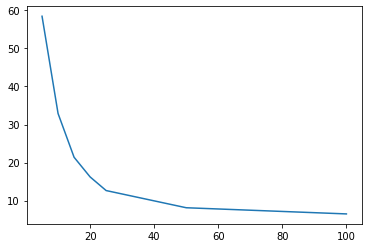

In [15]:
import matplotlib.pyplot as plt

X = df.drop(columns = 'medv').values
y = df['medv'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

res = []
for n_e in [5, 10, 15, 20, 25, 50, 100]:
    model = GradientBoostingEstimator(n_estimators=n_e, learning_rate=0.1, loss='mse')
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    error = mean_squared_error(pred, y_test)
    res.append(error)
plt.plot([5, 10, 15, 20, 25, 50, 100], res)

0 iteraton: hl: 80.31501286110013
1 iteraton: hl: 79.17544987851548
2 iteraton: hl: 78.0585938364884
3 iteraton: hl: 76.96405607651243
4 iteraton: hl: 75.89286557874469
0 iteraton: hl: 80.31501286110013
1 iteraton: hl: 79.17544987851548
2 iteraton: hl: 78.0585938364884
3 iteraton: hl: 76.96405607651243
4 iteraton: hl: 75.89286557874469
5 iteraton: hl: 74.83617073881672
6 iteraton: hl: 73.80245175652432
7 iteraton: hl: 72.80129724108548
8 iteraton: hl: 71.81225245221337
9 iteraton: hl: 70.84944691954409
0 iteraton: hl: 80.31501286110013
1 iteraton: hl: 79.17544987851548
2 iteraton: hl: 78.0585938364884
3 iteraton: hl: 76.96405607651243
4 iteraton: hl: 75.89286557874469
5 iteraton: hl: 74.83617073881672
6 iteraton: hl: 73.80245175652432
7 iteraton: hl: 72.80129724108548
8 iteraton: hl: 71.81225245221337
9 iteraton: hl: 70.84944691954409
10 iteraton: hl: 69.88871161503835
11 iteraton: hl: 68.95686080610339
12 iteraton: hl: 68.02789382075962
13 iteraton: hl: 67.1134334299517
14 iteraton: h

29 iteraton: hl: 53.844458999147015
30 iteraton: hl: 53.09104080729531
31 iteraton: hl: 52.347653781988534
32 iteraton: hl: 51.61707554660454
33 iteraton: hl: 50.923705506920534
34 iteraton: hl: 50.21199368162123
35 iteraton: hl: 49.524482561035946
36 iteraton: hl: 48.83470828264666
37 iteraton: hl: 48.165188449826324
38 iteraton: hl: 47.50143246329321
39 iteraton: hl: 46.849782733554115
40 iteraton: hl: 46.2041910595463
41 iteraton: hl: 45.554810720918105
42 iteraton: hl: 44.93569154084129
43 iteraton: hl: 44.32421350738306
44 iteraton: hl: 43.70338122300164
45 iteraton: hl: 43.118620232663034
46 iteraton: hl: 42.51079311901003
47 iteraton: hl: 41.934148854941306
48 iteraton: hl: 41.36605106325
49 iteraton: hl: 40.77254736610247
50 iteraton: hl: 40.22872913833104
51 iteraton: hl: 39.696646174755735
52 iteraton: hl: 39.17131876202314
53 iteraton: hl: 38.628201489744555
54 iteraton: hl: 38.122185177570245
55 iteraton: hl: 37.629743835743376
56 iteraton: hl: 37.134810875034816
57 iterato

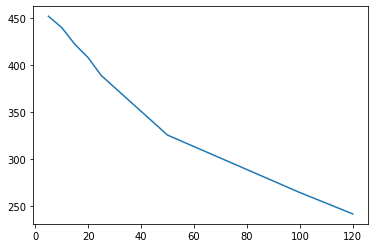

In [16]:
import matplotlib.pyplot as plt

X = df.drop(columns = 'medv').values
y = df['medv'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
res = []
for n_e in [5, 10, 15, 20, 25, 50, 100, 120]:
    model = GradientBoostingEstimator(n_estimators=n_e, learning_rate=0.1, loss='hl')
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    error = huber_loss(pred, y_test)
    res.append(error)
plt.plot([5, 10, 15, 20, 25, 50, 100, 120], res)

0 iteraton: logloss: 9.881391813244182
1 iteraton: logloss: 9.881391813244182
2 iteraton: logloss: 9.881391813244182
3 iteraton: logloss: 9.881391813244182
4 iteraton: logloss: 9.881391813244182
0 iteraton: logloss: 9.881391813244182
1 iteraton: logloss: 9.881391813244182
2 iteraton: logloss: 9.881391813244182
3 iteraton: logloss: 9.881391813244182
4 iteraton: logloss: 9.881391813244182
5 iteraton: logloss: 8.877547587338523
6 iteraton: logloss: 8.877547587338523
7 iteraton: logloss: 8.877547587338523
8 iteraton: logloss: 8.877547587338523
9 iteraton: logloss: 6.514777088578017
0 iteraton: logloss: 9.881391813244182
1 iteraton: logloss: 9.881391813244182
2 iteraton: logloss: 9.881391813244182
3 iteraton: logloss: 9.881391813244182
4 iteraton: logloss: 9.881391813244182
5 iteraton: logloss: 8.877547587338523
6 iteraton: logloss: 8.877547587338523
7 iteraton: logloss: 8.877547587338523
8 iteraton: logloss: 8.877547587338523
9 iteraton: logloss: 6.514777088578017
10 iteraton: logloss: 6.5

83 iteraton: logloss: 6.118709696826598
84 iteraton: logloss: 6.117002476402748
85 iteraton: logloss: 6.117002476402748
86 iteraton: logloss: 6.118709696826598
87 iteraton: logloss: 6.113588035555048
88 iteraton: logloss: 6.096516779877584
89 iteraton: logloss: 6.117002476402748
90 iteraton: logloss: 6.118709696826598
91 iteraton: logloss: 6.06237399185902
92 iteraton: logloss: 6.113588035555048
93 iteraton: logloss: 6.117002476402748
94 iteraton: logloss: 6.118709696826598
95 iteraton: logloss: 6.113588035555048
96 iteraton: logloss: 6.117002476402748
97 iteraton: logloss: 6.118709696826598
98 iteraton: logloss: 6.113588035555048
99 iteraton: logloss: 6.117002476402748
0 iteraton: logloss: 9.881391813244182
1 iteraton: logloss: 9.881391813244182
2 iteraton: logloss: 9.881391813244182
3 iteraton: logloss: 9.881391813244182
4 iteraton: logloss: 9.881391813244182
5 iteraton: logloss: 8.877547587338523
6 iteraton: logloss: 8.877547587338523
7 iteraton: logloss: 8.877547587338523
8 iterato

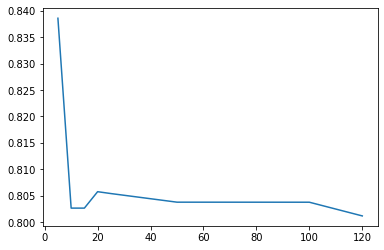

In [17]:
df_X = pd.read_csv('../s10-ensembles/data/x_train.csv', sep=';')
df_y = pd.read_csv('../s10-ensembles/data/y_train.csv', sep=';', header=None, names=['target'])

X = df_X.values
y = df_y['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
res = []
for n_e in [5, 10, 15, 20, 25, 50, 100, 120]:
    model = GradientBoostingEstimator(n_estimators=n_e, learning_rate=0.1, loss='logloss')
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    error = roc_auc_score(pred, y_test)
    res.append(error)
plt.plot([5, 10, 15, 20, 25, 50, 100, 120], res)

# Task 4 (1 point)
Plot dependecy of loss value (in classification task plot roc-auc score) from `learning_rate` of your boosting. Use `n_estimators=100`.

0 iteraton: mse: 89.1387370682345
1 iteraton: mse: 75.0036319321697
2 iteraton: mse: 63.45602663551346
3 iteraton: mse: 53.67186137080742
4 iteraton: mse: 46.09050996586824
5 iteraton: mse: 39.39858600418817
6 iteraton: mse: 34.15471838708177
7 iteraton: mse: 29.477991071869415
8 iteraton: mse: 25.568225404974232
9 iteraton: mse: 22.217733443593843
10 iteraton: mse: 19.518602696710104
11 iteraton: mse: 17.274744361223288
12 iteraton: mse: 15.431639646193828
13 iteraton: mse: 13.881358134082165
14 iteraton: mse: 12.507365034264861
15 iteraton: mse: 11.329717065860045
16 iteraton: mse: 10.360625677240515
17 iteraton: mse: 9.537434936883043
18 iteraton: mse: 8.83856274007557
19 iteraton: mse: 8.207113250150982
20 iteraton: mse: 7.735799064299821
21 iteraton: mse: 7.232954789040488
22 iteraton: mse: 6.8251435941268594
23 iteraton: mse: 6.440908415117415
24 iteraton: mse: 6.100480580217833
25 iteraton: mse: 5.789751971429183
26 iteraton: mse: 5.5354907285096315
27 iteraton: mse: 5.319402220

27 iteraton: mse: 1.5496980074648201
28 iteraton: mse: 1.485825738316592
29 iteraton: mse: 1.4351924585414204
30 iteraton: mse: 1.3793810829541142
31 iteraton: mse: 1.292737941025033
32 iteraton: mse: 1.257711158706725
33 iteraton: mse: 1.1588292184254279
34 iteraton: mse: 1.0723614731374982
35 iteraton: mse: 1.0166977714231968
36 iteraton: mse: 0.9785232130760292
37 iteraton: mse: 0.9177255529701172
38 iteraton: mse: 0.8572453963434764
39 iteraton: mse: 0.7991473876063168
40 iteraton: mse: 0.7751498590251872
41 iteraton: mse: 0.7342030630739476
42 iteraton: mse: 0.6892473049617529
43 iteraton: mse: 0.6750342593721752
44 iteraton: mse: 0.666754812345806
45 iteraton: mse: 0.6503983962037594
46 iteraton: mse: 0.6151603600503814
47 iteraton: mse: 0.6038689189062397
48 iteraton: mse: 0.5892100256262178
49 iteraton: mse: 0.5757899285477747
50 iteraton: mse: 0.556189536132016
51 iteraton: mse: 0.5517143147934902
52 iteraton: mse: 0.5442060709004936
53 iteraton: mse: 0.5254048441321788
54 ite

52 iteraton: mse: 0.1582618704491726
53 iteraton: mse: 0.14188786330284486
54 iteraton: mse: 0.13515769859272922
55 iteraton: mse: 0.1284572684284301
56 iteraton: mse: 0.12374773553097888
57 iteraton: mse: 0.12035307740367608
58 iteraton: mse: 0.11552961575848969
59 iteraton: mse: 0.1075674209692474
60 iteraton: mse: 0.10234868516214245
61 iteraton: mse: 0.09837505739077661
62 iteraton: mse: 0.08883098766056327
63 iteraton: mse: 0.08579480414298542
64 iteraton: mse: 0.07630831215005518
65 iteraton: mse: 0.07108220955758124
66 iteraton: mse: 0.06653920947696645
67 iteraton: mse: 0.06403213624391485
68 iteraton: mse: 0.06040327259402065
69 iteraton: mse: 0.059242143157704735
70 iteraton: mse: 0.0565047086829827
71 iteraton: mse: 0.05438675193625496
72 iteraton: mse: 0.05100024441819473
73 iteraton: mse: 0.05043312705967869
74 iteraton: mse: 0.048695106033389085
75 iteraton: mse: 0.045020573461258664
76 iteraton: mse: 0.04291776299270019
77 iteraton: mse: 0.03669707593705734
78 iteraton: 

75 iteraton: mse: 0.010233143471194073
76 iteraton: mse: 0.00930373014814506
77 iteraton: mse: 0.00912322738576484
78 iteraton: mse: 0.008697983274049149
79 iteraton: mse: 0.008301303991959025
80 iteraton: mse: 0.008232090631906278
81 iteraton: mse: 0.007369064664947773
82 iteraton: mse: 0.006351648540267178
83 iteraton: mse: 0.005796218527703793
84 iteraton: mse: 0.005194953348644558
85 iteraton: mse: 0.0043627477902388875
86 iteraton: mse: 0.004023406488281313
87 iteraton: mse: 0.003737806346191882
88 iteraton: mse: 0.0034808334941582456
89 iteraton: mse: 0.0030852399582073195
90 iteraton: mse: 0.0029851669315649207
91 iteraton: mse: 0.002753054730543075
92 iteraton: mse: 0.002494806112419083
93 iteraton: mse: 0.0021838271434678025
94 iteraton: mse: 0.002022080038509678
95 iteraton: mse: 0.001822909051645058
96 iteraton: mse: 0.001784092039374795
97 iteraton: mse: 0.0016667914944496287
98 iteraton: mse: 0.001485770080374805
99 iteraton: mse: 0.00132899663811647
11.686841746079553


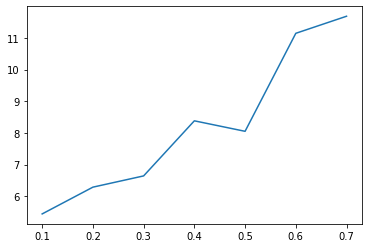

In [18]:
import matplotlib.pyplot as plt

X = df.drop(columns = 'medv').values
y = df['medv'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

res = []
for lr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    model = GradientBoostingEstimator(n_estimators=100, learning_rate=lr, loss='mse')
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    error = mean_squared_error(pred, y_test)
    print(error)
    res.append(error)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], res)

0 iteraton: hl: 80.5631019277517
1 iteraton: hl: 79.45930636639764
2 iteraton: hl: 78.37070798963374
3 iteraton: hl: 77.30677794099756
4 iteraton: hl: 76.22846114595578
5 iteraton: hl: 75.17225696759301
6 iteraton: hl: 74.13945486040124
7 iteraton: hl: 73.11571316705185
8 iteraton: hl: 72.14908862470286
9 iteraton: hl: 71.16929460821552
10 iteraton: hl: 70.2060369640285
11 iteraton: hl: 69.29158207879209
12 iteraton: hl: 68.3655727533972
13 iteraton: hl: 67.44619451877023
14 iteraton: hl: 66.54252863575985
15 iteraton: hl: 65.65513567861991
16 iteraton: hl: 64.78869982567093
17 iteraton: hl: 63.917038985214845
18 iteraton: hl: 63.05907004317586
19 iteraton: hl: 62.21933984482397
20 iteraton: hl: 61.39431062392052
21 iteraton: hl: 60.58675952317939
22 iteraton: hl: 59.77037262731964
23 iteraton: hl: 59.01560824573125
24 iteraton: hl: 58.22901723406319
25 iteraton: hl: 57.451597096960356
26 iteraton: hl: 56.69826344103602
27 iteraton: hl: 55.940870921642
28 iteraton: hl: 55.2125450854004

39 iteraton: hl: 19.175118303743957
40 iteraton: hl: 18.540929810344117
41 iteraton: hl: 17.956900346465627
42 iteraton: hl: 17.436167163815085
43 iteraton: hl: 16.90753075824126
44 iteraton: hl: 16.42152310011297
45 iteraton: hl: 15.967504082287475
46 iteraton: hl: 15.580404015166428
47 iteraton: hl: 15.053953404071178
48 iteraton: hl: 14.683922620361002
49 iteraton: hl: 14.192821617842263
50 iteraton: hl: 13.856033988487752
51 iteraton: hl: 13.571630545143428
52 iteraton: hl: 13.268616802093778
53 iteraton: hl: 12.878077583778008
54 iteraton: hl: 12.489588768918503
55 iteraton: hl: 12.174716359314594
56 iteraton: hl: 11.893857685289674
57 iteraton: hl: 11.511938282959548
58 iteraton: hl: 11.144116254053591
59 iteraton: hl: 10.828937438380011
60 iteraton: hl: 10.46374950637997
61 iteraton: hl: 10.124911203455039
62 iteraton: hl: 9.79683037484823
63 iteraton: hl: 9.475004128150642
64 iteraton: hl: 9.247110283921083
65 iteraton: hl: 8.950855901072865
66 iteraton: hl: 8.663322528043262
6

75 iteraton: hl: 2.2538264416361713
76 iteraton: hl: 2.2136810490481484
77 iteraton: hl: 2.1564155507300136
78 iteraton: hl: 2.1212569208528507
79 iteraton: hl: 2.096997048641061
80 iteraton: hl: 2.0761774984208796
81 iteraton: hl: 2.0563075268422346
82 iteraton: hl: 2.022758856256445
83 iteraton: hl: 1.9688620503878582
84 iteraton: hl: 1.928576981366492
85 iteraton: hl: 1.8364752399684887
86 iteraton: hl: 1.7849237258297184
87 iteraton: hl: 1.7236120400024473
88 iteraton: hl: 1.6511887853577387
89 iteraton: hl: 1.5766172861818517
90 iteraton: hl: 1.5158140934467506
91 iteraton: hl: 1.4757220974615544
92 iteraton: hl: 1.4533786702874751
93 iteraton: hl: 1.3932877623128852
94 iteraton: hl: 1.3416789753613434
95 iteraton: hl: 1.318572235907376
96 iteraton: hl: 1.277728850325765
97 iteraton: hl: 1.239034964917543
98 iteraton: hl: 1.1939197084745197
99 iteraton: hl: 1.1498114325126727
0 iteraton: hl: 80.5631019277517
1 iteraton: hl: 74.14863710243307
2 iteraton: hl: 68.22765131454949
3 ite

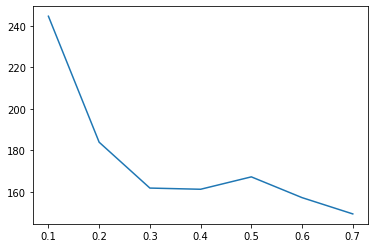

In [19]:
import matplotlib.pyplot as plt

X = df.drop(columns = 'medv').values
y = df['medv'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

res = []
for lr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    model = GradientBoostingEstimator(n_estimators=100, learning_rate=lr, loss='hl')
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    error = huber_loss(pred, y_test)
    res.append(error)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], res)

0 iteraton: logloss: 9.934315646383533
1 iteraton: logloss: 9.934315646383533
2 iteraton: logloss: 9.934315646383533
3 iteraton: logloss: 9.934315646383533
4 iteraton: logloss: 9.934315646383533
5 iteraton: logloss: 8.894619831100398
6 iteraton: logloss: 8.894619831100398
7 iteraton: logloss: 8.894619831100398
8 iteraton: logloss: 8.894619831100398
9 iteraton: logloss: 7.0559584534969515
10 iteraton: logloss: 7.0559584534969515
11 iteraton: logloss: 6.806706287307044
12 iteraton: logloss: 6.4942921825203825
13 iteraton: logloss: 6.4942921825203825
14 iteraton: logloss: 6.4942921825203825
15 iteraton: logloss: 6.485756080401132
16 iteraton: logloss: 6.359423231401159
17 iteraton: logloss: 6.356008790553459
18 iteraton: logloss: 6.3491799088580585
19 iteraton: logloss: 6.3491799088580585
20 iteraton: logloss: 6.344058247586508
21 iteraton: logloss: 6.11700097451444
22 iteraton: logloss: 6.11700097451444
23 iteraton: logloss: 6.11700097451444
24 iteraton: logloss: 6.125538064718104
25 ite

7 iteraton: logloss: 6.11700097451444
8 iteraton: logloss: 6.1972391487340985
9 iteraton: logloss: 6.031642522341411
10 iteraton: logloss: 6.035056686525475
11 iteraton: logloss: 5.954821120848667
12 iteraton: logloss: 5.947993385331186
13 iteraton: logloss: 6.084565011685961
14 iteraton: logloss: 5.9172657891044755
15 iteraton: logloss: 6.091393458624219
16 iteraton: logloss: 5.947994689602611
17 iteraton: logloss: 6.089686435817252
18 iteraton: logloss: 6.086272074016305
19 iteraton: logloss: 5.995795043395093
20 iteraton: logloss: 6.077737592355492
21 iteraton: logloss: 6.035060520292997
22 iteraton: logloss: 6.033353299869147
23 iteraton: logloss: 6.040181944424289
24 iteraton: logloss: 6.040181944424289
25 iteraton: logloss: 6.023109740185787
26 iteraton: logloss: 6.099931062631778
27 iteraton: logloss: 6.040181944424289
28 iteraton: logloss: 6.0965166613074535
29 iteraton: logloss: 6.040181944424289
30 iteraton: logloss: 6.089689439593867
31 iteraton: logloss: 6.033351797980838
3

15 iteraton: logloss: 5.837027891548455
16 iteraton: logloss: 6.175045994644824
17 iteraton: logloss: 6.175045994644824
18 iteraton: logloss: 5.837027891548455
19 iteraton: logloss: 6.175045994644824
20 iteraton: logloss: 6.175045994644824
21 iteraton: logloss: 6.091394407185256
22 iteraton: logloss: 5.8916569294194545
23 iteraton: logloss: 5.918972258584171
24 iteraton: logloss: 6.164802790671854
25 iteraton: logloss: 5.947994768649363
26 iteraton: logloss: 6.1682171919961775
27 iteraton: logloss: 5.951409169973687
28 iteraton: logloss: 6.171631632843877
29 iteraton: logloss: 5.9548236108213874
30 iteraton: logloss: 6.171631632843877
31 iteraton: logloss: 5.9548236108213874
32 iteraton: logloss: 6.214311827253117
33 iteraton: logloss: 5.9548236108213874
34 iteraton: logloss: 6.214311827253117
35 iteraton: logloss: 5.9548236108213874
36 iteraton: logloss: 6.214311827253117
37 iteraton: logloss: 5.997503805230626
38 iteraton: logloss: 6.171631632843877
39 iteraton: logloss: 6.1716316328

22 iteraton: logloss: 6.047009087091122
23 iteraton: logloss: 6.047009087091122
24 iteraton: logloss: 6.0333514027470745
25 iteraton: logloss: 6.047009087091122
26 iteraton: logloss: 6.0333514027470745
27 iteraton: logloss: 6.047009087091122
28 iteraton: logloss: 5.994088929625786
29 iteraton: logloss: 6.029937040946128
30 iteraton: logloss: 6.045301945714025
31 iteraton: logloss: 6.031644261369977
32 iteraton: logloss: 6.045301945714025
33 iteraton: logloss: 6.031644261369977
34 iteraton: logloss: 6.045301945714025
35 iteraton: logloss: 6.045301945714025
36 iteraton: logloss: 6.031644261369977
37 iteraton: logloss: 6.045301945714025
38 iteraton: logloss: 6.031644261369977
39 iteraton: logloss: 6.045301945714025
40 iteraton: logloss: 6.031644261369977
41 iteraton: logloss: 6.045301945714025
42 iteraton: logloss: 6.045301945714025
43 iteraton: logloss: 5.978724103904641
44 iteraton: logloss: 6.031644261369977
45 iteraton: logloss: 6.045301945714025
46 iteraton: logloss: 6.04530194571402

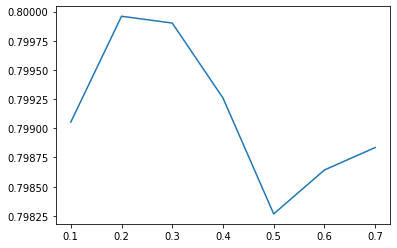

In [20]:
df_X = pd.read_csv('../s10-ensembles/data/x_train.csv', sep=';')
df_y = pd.read_csv('../s10-ensembles/data/y_train.csv', sep=';', header=None, names=['target'])

X = df_X.values
y = df_y['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
res = []
for lr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    model = GradientBoostingEstimator(n_estimators=100, learning_rate=lr, loss='logloss')
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    error = roc_auc_score(pred, y_test)
    res.append(error)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], res)